In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import bbi
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import bioframe as bf
import cooltools
import cooltools.lib.plotting
import cooler
from tqdm import tqdm
from itertools import product
from scipy.ndimage import gaussian_filter
from spt5_project_lib import PeaksManipulation

In [31]:
#### A way to use externel fonts in matplotlib without installing it
from matplotlib import font_manager
font_dirs = ['/users/ankit.gupta/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
#### A way to use externel fonts in matplotlib without installing it

mpl.rcParams['font.family'] = 'Nunito'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2

In [5]:
tssOvlp = pd.read_csv("../atac_h3k27ac_peaks_overlap/promoter_peaks_using_h3k27ac.tsv",sep="\t")

In [6]:
tssOvlp

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,distance
0,chr1,4774336,4776623,2287,chr1,4775770,4775870,Mrpl15,-,12533,0
1,chr1,7077974,7079799,1825,chr1,7078951,7079051,Pcmtd1,+,84706,0
2,chr1,7386778,7389174,2396,chr1,7387832,7387932,Gm16899,-,48395,0
3,chr1,9534577,9536304,1727,chr1,9535439,9535539,Rrs1,+,2046,0
4,chr1,9689154,9691474,2320,chr1,9690240,9690340,Mybl1,-,32794,0
...,...,...,...,...,...,...,...,...,...,...,...
9638,chrX,155809856,155811271,1415,chrX,155810060,155810160,Eif1ax,+,17750,0
9639,chrX,156064631,156066938,2307,chrX,156065154,156065254,Sh3kbp1,+,350797,0
9640,chrX,160395856,160397466,1610,chrX,160396543,160396643,Zrsr2,-,23218,0
9641,chrX,160857433,160858497,1064,chrX,160857675,160857775,Piga,+,14123,0


In [7]:
genes = pd.read_csv("../../results/files/mm9.genes.info.csv")
# genes = genes.drop_duplicates(subset=["gene_name"])
genes["gene_len"] = abs(genes.end - genes.start)
genes = genes.rename(columns={"gene_name":"gene_name_"})

In [8]:
genes

,chrom,start,end,gene_name_,strand,gene_len
0,chr1,3044314,3044814,Gm16088,+,500
1,chr1,3092097,3092206,U6,+,109
2,chr1,3195982,3661579,Xkr4,-,465597
3,chr1,3456668,3503634,Gm1992,+,46966
4,chr1,3668961,3669024,U7,-,63
...,...,...,...,...,...,...
37578,chrY,2086590,2097768,Rbmy1a1,+,11178
37579,chrY,2118049,2129045,Gm10256,+,10996
37580,chrY,2156899,2168120,Gm10352,+,11221
37581,chrY,2390390,2398856,Gm3376,+,8466


In [9]:
expressedGenes = tssOvlp.copy()#.query("biotype_ == 'protein_coding'",engine="python")
expressedGenes = pd.merge(expressedGenes, genes ,on=["chrom","gene_name_"], how="left",suffixes=["","_g"])
expressedGenes = expressedGenes.drop_duplicates(subset=["chrom","gene_name_"]).reset_index(drop=True)
expressedGenes = PeaksManipulation.GetIntervalsFromPeaks(expressedGenes,500)
expressedGenes

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,distance,start_g,end_g,strand,gene_len
0,chr1,4774979,4775979,2287,chr1,4775770,4775870,Mrpl15,-,12533,0,4763287,4775820,-,12533
1,chr1,7078386,7079386,1825,chr1,7078951,7079051,Pcmtd1,+,84706,0,7079001,7163707,+,84706
2,chr1,7387476,7388476,2396,chr1,7387832,7387932,Gm16899,-,48395,0,7339487,7387882,-,48395
3,chr1,9534940,9535940,1727,chr1,9535439,9535539,Rrs1,+,2046,0,9535489,9537535,+,2046
4,chr1,9689814,9690814,2320,chr1,9690240,9690340,Mybl1,-,32794,0,9657496,9690290,-,32794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,chrX,155810063,155811063,1415,chrX,155810060,155810160,Eif1ax,+,17750,0,155810110,155827860,+,17750
9578,chrX,156065284,156066284,2307,chrX,156065154,156065254,Sh3kbp1,+,350797,0,156065204,156416001,+,350797
9579,chrX,160396161,160397161,1610,chrX,160396543,160396643,Zrsr2,-,23218,0,160373375,160396593,-,23218
9580,chrX,160857465,160858465,1064,chrX,160857675,160857775,Piga,+,14123,0,160857725,160871848,+,14123


## loading files

### GRO-seq

In [10]:
groSeqFiles=glob.glob(r"/groups/goloborodko/projects/ankit/spt5_project/mapped/mm9/*.bw")
groSeqFiles = [i for i in groSeqFiles if "5p" not in i]
excNames = dict(plus="fwd",minus="rev")
groSeqDict = {"WT.R1":{"fwd":"","rev":""},"WT.R2":{"fwd":"","rev":""}, "KO.R1":{"fwd":"","rev":""},"KO.R2":{"fwd":"","rev":""}}
for i in groSeqFiles:
    nameList = i.split("/")[-1].split(".")
    groSeqDict[f"{nameList[0]}.{nameList[1]}"][excNames[nameList[2]]] = bbi.open(i)

In [11]:
%%time
genesGroSeqCov = {"WT":{},"KO":{}}
sampleName = "gro_seq"
sampleDict = groSeqDict
df = expressedGenes

strandCol = "strand_"
strandMask = np.array(df[strandCol] == '-', dtype=bool)

for i in (genesGroSeqCov.keys()):
    genesGroSeqCov[i]["fwd"] = groSeqDict[f"{i}.R1"]["fwd"].stackup(df.chrom,
                                                                    df.start_g,
                                                                    df.end_g,
                                                                    summary='sum',
                                                                    bins=1).flatten()
    genesGroSeqCov[i]["fwd"] += groSeqDict[f"{i}.R2"]["fwd"].stackup(df.chrom,
                                                                    df.start_g,
                                                                    df.end_g,
                                                                    summary='sum',
                                                                    bins=1).flatten()
    
    genesGroSeqCov[i]["rev"] = groSeqDict[f"{i}.R1"]["rev"].stackup(df.chrom,
                                                                    df.start_g,
                                                                    df.end_g,
                                                                    summary='sum',
                                                                    bins=1).flatten()
    genesGroSeqCov[i]["rev"] += groSeqDict[f"{i}.R2"]["rev"].stackup(df.chrom,
                                                                    df.start_g,
                                                                    df.end_g,
                                                                    summary='sum',
                                                                    bins=1).flatten()
    genesGroSeqCov[i]["fwd"]/=2#*expressedGenes.gene_len
    genesGroSeqCov[i]["rev"]/=2#*expressedGenes.gene_len
    expressedGenes[f"{i}_fwd"] = genesGroSeqCov[i]["fwd"]/expressedGenes["gene_len"]
    expressedGenes[f"{i}_rev"] = genesGroSeqCov[i]["rev"]/expressedGenes["gene_len"]

CPU times: user 15.6 s, sys: 426 ms, total: 16 s
Wall time: 22.5 s


In [12]:
WT_exp = np.zeros(len(expressedGenes))
KO_exp = np.zeros(len(expressedGenes))

WT_exp[strandMask] = expressedGenes["WT_rev"][strandMask]
WT_exp[~strandMask] = expressedGenes["WT_fwd"][~strandMask]
KO_exp[strandMask] = expressedGenes["KO_rev"][strandMask]
KO_exp[~strandMask] = expressedGenes["KO_fwd"][~strandMask]

expressedGenes = expressedGenes.assign(WT_exp=WT_exp, KO_exp=KO_exp)

In [13]:
expressedGenes

,chrom,start,end,length,chrom_,start_,end_,gene_name_,strand_,gene_len_,...,start_g,end_g,strand,gene_len,WT_fwd,WT_rev,KO_fwd,KO_rev,WT_exp,KO_exp
0,chr1,4774979,4775979,2287,chr1,4775770,4775870,Mrpl15,-,12533,...,4763287,4775820,-,12533,0.010635,0.144268,0.013622,0.163906,0.144268,0.163906
1,chr1,7078386,7079386,1825,chr1,7078951,7079051,Pcmtd1,+,84706,...,7079001,7163707,+,84706,0.098776,0.008151,0.058655,0.004887,0.098776,0.058655
2,chr1,7387476,7388476,2396,chr1,7387832,7387932,Gm16899,-,48395,...,7339487,7387882,-,48395,0.002191,0.046365,0.001702,0.017107,0.046365,0.017107
3,chr1,9534940,9535940,1727,chr1,9535439,9535539,Rrs1,+,2046,...,9535489,9537535,+,2046,0.422500,0.010980,0.394544,0.011962,0.422500,0.394544
4,chr1,9689814,9690814,2320,chr1,9690240,9690340,Mybl1,-,32794,...,9657496,9690290,-,32794,0.003656,0.078436,0.004059,0.128330,0.078436,0.128330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,chrX,155810063,155811063,1415,chrX,155810060,155810160,Eif1ax,+,17750,...,155810110,155827860,+,17750,0.145063,0.005307,0.187500,0.004115,0.145063,0.187500
9578,chrX,156065284,156066284,2307,chrX,156065154,156065254,Sh3kbp1,+,350797,...,156065204,156416001,+,350797,0.057685,0.003634,0.037834,0.002980,0.057685,0.037834
9579,chrX,160396161,160397161,1610,chrX,160396543,160396643,Zrsr2,-,23218,...,160373375,160396593,-,23218,0.015905,0.219807,0.021923,0.249231,0.219807,0.249231
9580,chrX,160857465,160858465,1064,chrX,160857675,160857775,Piga,+,14123,...,160857725,160871848,+,14123,0.096174,0.002579,0.098740,0.001220,0.096174,0.098740


## MicroC

In [14]:
microCRes = 1000
cools = {}
cools["WT"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/WT.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
cools["KO"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/KO.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
mm9_chromsizes = bf.fetch_chromsizes('mm9')
mm9_cens = bf.fetch_centromeres('mm9') ### Mouse chromosomes are telocentric
mm9_chroms = bf.core.construction.add_ucsc_name_column(bf.make_chromarms(mm9_chromsizes,  mm9_cens))
mm9_chroms = mm9_chroms[mm9_chroms.chrom.isin(cools["WT"].chromnames)].reset_index(drop=True)

In [15]:
%%time
expectedWT = pd.read_csv("../microC_pileups/expected_cis_WT_group_1kb_res.tsv",sep="\t")
expectedKO = pd.read_csv("../microC_pileups/expected_cis_KO_group_1kb_res.tsv",sep="\t")

loopsFlankbig = 40_000
tssPileup = {}
tssPileup = dict(WT=cooltools.pileup(cools["WT"], expressedGenes, view_df=mm9_chroms,expected_df=expectedWT, flank=loopsFlankbig, nproc=10), 
                 KO=cooltools.pileup(cools["KO"], expressedGenes, view_df=mm9_chroms,expected_df=expectedKO, flank=loopsFlankbig, nproc=10))

CPU times: user 42.2 s, sys: 25 s, total: 1min 7s
Wall time: 6min 41s


---

## Getting Pileups

In [16]:
pileupsDict = {}

0-5kb	9582


<timed exec>:29: RuntimeWarning: divide by zero encountered in log10
<timed exec>:38: RuntimeWarning: divide by zero encountered in log10
<timed exec>:46: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 12.1 s, sys: 4.96 s, total: 17.1 s
Wall time: 15.8 s


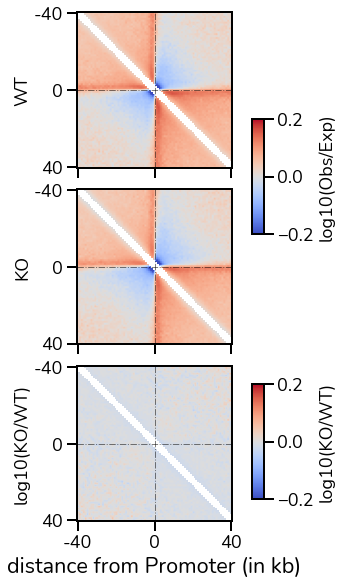

In [36]:
%%time

pileupKwargsDictOE = dict(cmap="coolwarm",aspect="auto",vmin=-0.20,vmax=0.20)
pileupKwargsDictRatio = dict(cmap="coolwarm",aspect="auto",vmin=-0.2,vmax=0.2)

fig,ax = plt.subplots(3,1,figsize=(4,8),sharex=True,sharey=True,constrained_layout=True)
distRanges = {"0-5kb": "(gene_len > 0)",
              # "0-5kb": "(gene_len < 5000)", 
              # "5-20kb": "(5000 < gene_len < 20_000)", 
              # "20-50kb": "(20_000 < gene_len < 50_000)", 
              # "50-100kb": "(50_000 < gene_len < 100_000)", 
              # "100-1000kb": "(100_000 < gene_len < 1_000_000)"
             }
centerAt = loopsFlankbig // microCRes
ax[0].set_xticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])
ax[0].set_yticks([0,centerAt,centerAt*2],[-loopsFlankbig//1000,0,loopsFlankbig//1000])

ax[0].set_ylabel("WT")
ax[1].set_ylabel("KO")
ax[2].set_ylabel("log10(KO/WT)")
for ic,i in enumerate(distRanges.keys()):
    
    # ax[0].set_title(i)
    pileupKwargsDict = pileupKwargsDictOE
    df = expressedGenes.query(distRanges[i],engine="python")
    print(i,len(df),sep="\t")
    mask = np.array(df.strand == '-', dtype=bool)

    covWT = tssPileup["WT"][:,:,list(df.index)].copy()
    covWT[:, :, mask] = covWT[::-1, ::-1, mask]
    ax[0].imshow(np.log10(np.nanmean(covWT,axis=2)),**pileupKwargsDict)
    ax[0].axvline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[0].axhline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[0].set_aspect(1)
    # ax[0].spines.bottom.set_visible(False)
    # ax[0].spines.left.set_visible(False)

    covKO = tssPileup["KO"][:,:,list(df.index)].copy()
    covKO[:, :, mask] = covKO[::-1, ::-1, mask]
    ax[1].imshow(np.log10(np.nanmean(covKO,axis=2)),**pileupKwargsDict)
    ax[1].axvline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[1].axhline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[1].set_aspect(1)
    # ax[1].spines.bottom.set_visible(False)
    # ax[1].spines.left.set_visible(False)
    
    pileupKwargsDict = pileupKwargsDictRatio
    ratio = np.log10(np.nanmean(covKO,axis=2)/np.nanmean(covWT,axis=2))
    ax[2].imshow(ratio,**pileupKwargsDict)
    ax[2].axvline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[2].axhline(centerAt, lw=1, alpha=0.5, ls="-.", c="k")
    ax[2].set_aspect(1)
    # ax[2].spines.bottom.set_visible(True)
    # ax[2].spines.left.set_visible(True)
    
    
ax2 = fig.add_axes([0.84, 0.6,0.04, 0.2])
cb2 = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.20, 0.20),label="log10(Obs/Exp)")

ax3 = fig.add_axes([0.84, 0.14,0.04, 0.2])
cb3 = mpl.colorbar.ColorbarBase(ax3, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.20, 0.20),label="log10(KO/WT)")

# fig.suptitle(f"Pileups at TSS sites $\pm$ {loopsFlankbig//1000}kb (Obs/Exp) at different genes lengths ({microCRes//1000}kb MicroC)")
# fig.supylabel("distance from TSS (in kb)")
fig.supxlabel("distance from Promoter (in kb)")

# plt.savefig("microC_pileup_at_promoters.png",dpi=300,bbox_inches="tight")
# plt.savefig("microC_pileup_at_promoters.pdf",dpi=300,bbox_inches="tight")